# Advance Lane Lines

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Import useful packages

In [68]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import pickle
%matplotlib inline

## Configuration

In [69]:
nx = 9
ny = 6
points_file = "camera_cal/points.p"

## Calibrating Camera

In [70]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    print('processing image ' + fname)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
    else:
        print('No corner found')
        

calibrated_data = {'objpoints': objpoints, 'imgpoints': imgpoints}
with open(points_file, 'wb') as f:
    pickle.dump(calibrated_data, file=f)
print("Prcoess camera cal image done")


processing image camera_cal/calibration1.jpg
No corner found
processing image camera_cal/calibration10.jpg
processing image camera_cal/calibration11.jpg
processing image camera_cal/calibration12.jpg
processing image camera_cal/calibration13.jpg
processing image camera_cal/calibration14.jpg
processing image camera_cal/calibration15.jpg
processing image camera_cal/calibration16.jpg
processing image camera_cal/calibration17.jpg
processing image camera_cal/calibration18.jpg
processing image camera_cal/calibration19.jpg
processing image camera_cal/calibration2.jpg
processing image camera_cal/calibration20.jpg
processing image camera_cal/calibration3.jpg
processing image camera_cal/calibration4.jpg
No corner found
processing image camera_cal/calibration5.jpg
No corner found
processing image camera_cal/calibration6.jpg
processing image camera_cal/calibration7.jpg
processing image camera_cal/calibration8.jpg
processing image camera_cal/calibration9.jpg
Prcoess camera cal image done


In [71]:

def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist



def display_image(img, dst):
    dst_display = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img_display)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst_display)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.show()
    
    
def process_image(fname, objpoints, imgpoints):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    dst = cal_undistort(img, objpoints, imgpoints)
    display_image(img,dst)
    return dst

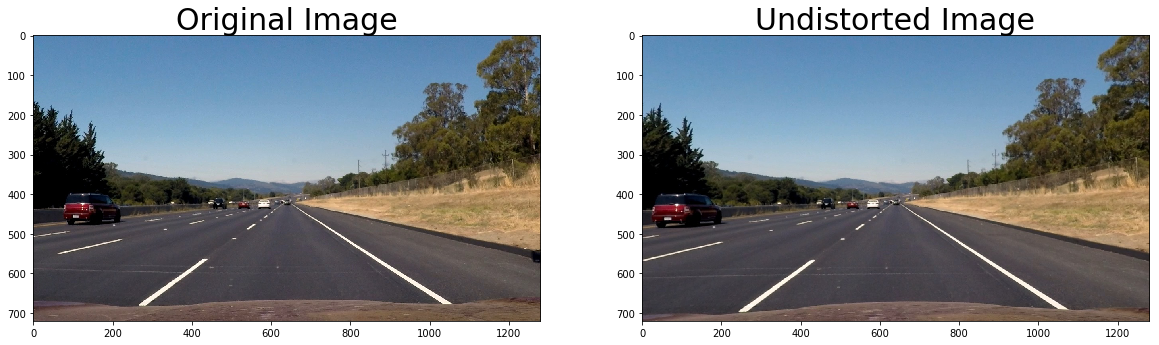

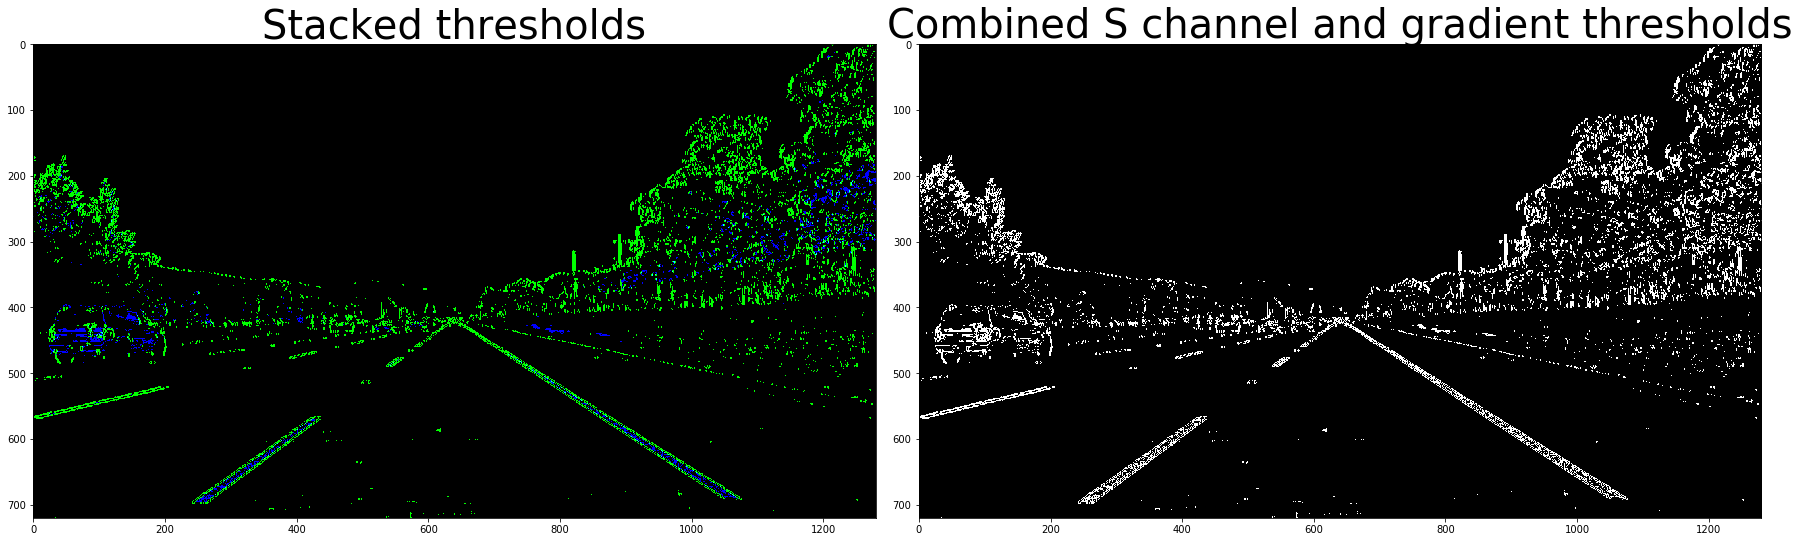

In [72]:
def color_sobel(img, s_thresh=(170, 220), sx_thresh=(20, 100), img_format='BGR'):
    # Convert to HSV color space and separate the V channel
    if img_format == 'BGR':
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float)
    else:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float)



    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(gray)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return (color_binary, combined_binary)

def desplay_color(dst, color_binary):
#     dst_display = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(dst)
    ax1.set_title('Stacked thresholds', fontsize=40)

    ax2.imshow(color_binary, cmap='gray')
    ax2.set_title('Combined S channel and gradient thresholds', fontsize=40)    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

with open(points_file, 'rb') as f:
    calibrated_data = pickle.load(file=f)
dst = process_image('test_images/straight_lines2.jpg', calibrated_data['objpoints'], calibrated_data['imgpoints'])

# process_image('test_images/test2.jpg', objpoints, imgpoints)
color_binary, combined_binary = color_sobel(dst)
desplay_color(color_binary, combined_binary)



## Persective Transformation

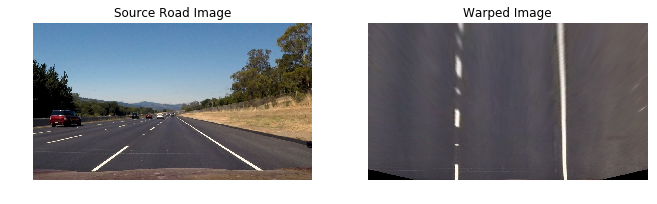

In [73]:
img = mpimg.imread('test_images/straight_lines2.jpg')
img_size = (img.shape[1], img.shape[0])


# By absolute value
# corners = np.float32([[253, 697],[585,456],[700, 456],[1061,690]])
# new_top_left = np.array([corners[0, 0], 0])
# new_top_right = np.array([corners[3, 0], 0])
# offset = [50, 0]
# src = np.float32([corners[0], corners[1], corners[2], corners[3]])
# dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])

# By percentage 

def get_perspective_matrix(img_size):
    bot_width = 0.76
    mid_width = 0.09
    height_pct = 0.62
    bot_pct = 0.935
    offset = img_size[0] * 0.25
    src = np.float32([
        [img_size[0]*(0.5 - mid_width/2), img_size[1] *height_pct ],
        [img_size[0]*(0.5 + mid_width/2), img_size[1] *height_pct ],
        [img_size[0]*(0.5 + bot_width/2), img_size[1] *bot_pct ],
        [img_size[0]*(0.5 - bot_width/2), img_size[1] *bot_pct ]
    ])

    dst = np.float32([
        [offset,0], 
        [img_size[0] - offset, 0], 
        [img_size[0] - offset, img_size[1]], 
        [offset, img_size[1]]
    ])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


M, Minv = get_perspective_matrix(img_size)

warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Source Road Image')
plt.imshow(img)


plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Warped Image')
plt.imshow(warped_img)

plt.show()

## Apply undistort and threshould and wrap

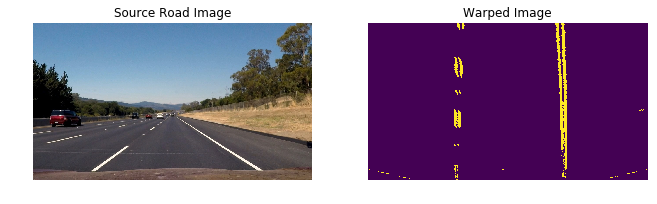

In [74]:

def full_process(fname, objpoints, imgpoints):
    img = mpimg.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    undistort = cal_undistort(img, objpoints, imgpoints)
    warped_img = cv2.warpPerspective(undistort, M, img_size, flags=cv2.INTER_LINEAR)
    color_binary, combined_binary = color_sobel(warped_img, (170, 220),(20, 100), img_format='BGR')

    plt.figure(figsize=(11, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title('Source Road Image')
    plt.imshow(img)


    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title('Warped Image')
    plt.imshow(combined_binary)
    return combined_binary

with open(points_file, 'rb') as f:
    calibrated_data = pickle.load(file=f)
combined_binary = full_process('test_images/straight_lines2.jpg', calibrated_data['objpoints'], calibrated_data['imgpoints'])


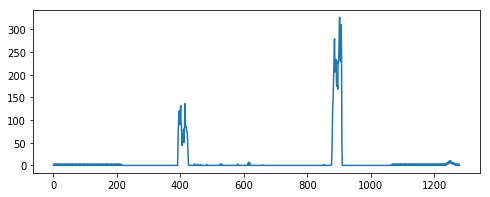

In [75]:

histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
plt.figure(figsize=(8, 3))
plt.plot(histogram)
plt.show()

done
720
720


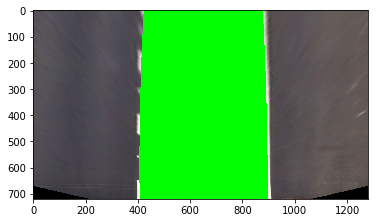

In [76]:
binary_warped = combined_binary

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
print("done")

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


print(len(left_fitx))
print(len(ploty))

line_left = []
for i in range(len(left_fitx)):
    line_left.append((left_fitx[i],ploty[i]))
pts_left = np.int32([line_left])

line_right = []
for i in range(len(right_fitx)):
    line_right.append((right_fitx[i],ploty[i]))

line_right.reverse()
pts_right = np.int32([line_right])

    
# print(line_left)
ouput_just_plot = warped_img


out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


# cv2.polylines(ouput_just_plot, np.int32([line_left]), isClosed=False, color=[255, 0,0], thickness=10)
# cv2.polylines(ouput_just_plot, np.int32([line_right]), isClosed=False, color=[255, 0,0], thickness=10)

pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(ouput_just_plot, pts, (0, 255, 0))

plt.imshow(ouput_just_plot)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)


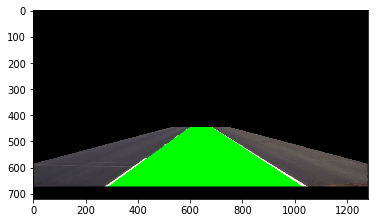

In [77]:
img_size = (out_img.shape[1], out_img.shape[0])

line_on_orig_image = cv2.warpPerspective(ouput_just_plot, Minv, img_size, flags=cv2.INTER_LINEAR)



plt.imshow(line_on_orig_image)
